In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
from sklearn.metrics import f1_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier #0.76 acc score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import Perceptron
from sklearn.linear_model import LogisticRegression
from statistics import mean
from sklearn import preprocessing
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import plot_confusion_matrix

In [2]:
stop_words = stopwords.words('english')

# Returns a boolean value if the word given is a stop word
def is_a_stop_word(word):
    return word in stop_words
 
# Removes stop words from given text
def remove_stop_words(text):
    words = text.split()
    new_text = ""
    for word in words:
        if not is_a_stop_word(word):
            new_text = new_text + word + " "
    return new_text 

# Cleans a comment of different emojis, symbols, punctuation etc. and stop words
def clean_comments(comment, remove_sw = True):
    #first remove apostrphes commas signs...
    no_space_replacement = re.compile(r'[.\'<>,\"#)%(’‘–]')
    space_replacement = re.compile(r'/')
    #Then emojis
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    
    clean_comment = no_space_replacement.sub('', comment)
    clean_comment = space_replacement.sub(' ', clean_comment)
    more_clean = emoji_pattern.sub(r'', clean_comment)
    if remove_sw:
        more_clean = remove_stop_words(more_clean.lower())
    return more_clean
    
#Have the labeled output in the last column
def reorganize_columns(df):
    original_col_list = list(df.columns)
    new_col_list = original_col_list[::-1]
    reorganized_df = df[new_col_list]
    return reorganized_df

#Deal with annotations... take the most common opinion.
def compact_annotations(annotation_list):
    most_common_annotations = list()
    
    for annotation in annotation_list:
        string = str(annotation)
        opinions = string.split('/')
        most_common_opinion = Counter(opinions).most_common(1)[0][0]
        most_common_annotations.append(most_common_opinion)
    
    return most_common_annotations

#Measure opinion agreement
def consensus(annot_list):
    agreement_rates = list()
    for annot in annot_list:
        opinion_count = Counter(annot).most_common(1)[0][1]
        rate = opinion_count/len(annot)

        #Which opinion is the most common, divide
        #by the total number of opinions and get the rate of the most common one
        #and if rate is 0.5, remove those rows
        
        if rate > 0.5:
        
            if Counter(annot).most_common(1)[0][0] == '1':
                agreement_rates.append(('pro-brexit', rate))
            elif Counter(annot).most_common(1)[0][0] == '0':
                agreement_rates.append(('anti-brexit', rate))
            else:
                agreement_rates.append(('non-cat', rate))
        
        else:
            
            agreement_rates.append(('contradicting', rate))
            
    return agreement_rates

#Remove comments (rows) with contradicting opinion
def remove_conflicts(data_frame):
    for row in data_frame.iterrows():
        annot = row[1]['Annotations'].split('/') 
        ctr = Counter(annot)
        #If mostly '-1'      DELETE
        #If same '0' and '1' DELETE
        #If 1/-1   or   0/-1 ?????
        if (ctr['0'] == ctr['1']) or (ctr.most_common(1)[0][0] == '-1'): #(ctr['0'] == ctr['-1']) or (ctr['1'] == ctr['-1']):
            # Drop the row from the dataframe, since the sentiment is not clear
            data_frame.drop(index=row[0], inplace=True)
        
    return data_frame

#Remove comments (rows) with contradicting opinion, also filters by rate
def remove_conflicts_by_rate(data_frame):
    for row in data_frame.iterrows():
        annot = row[1]['Annotations'].split('/') 
        ctr = Counter(annot)
        rate = ctr.most_common(1)[0][1]/len(annot)
        #If mostly '-1'      DELETE
        #If same '0' and '1' DELETE
        #If 1/-1   or   0/-1 ?????
        if (ctr['0'] == ctr['1']) or (ctr.most_common(1)[0][0] == '-1'): #(ctr['0'] == ctr['-1']) or (ctr['1'] == ctr['-1']):
            # Drop the row from the dataframe, since the sentiment is not clear
            data_frame.drop(index=row[0], inplace=True)
        elif rate < 0.6:
            # Drop the row if the majority is too small of a fraction
            data_frame.drop(index=row[0], inplace=True)
        
    return data_frame
    

In [3]:
#Read data
df = pd.read_csv('a2a_train_final.tsv', sep='\t', names = ["Annotations", "Comment"])

#Re-organize data
df = reorganize_columns(df)

Text(0.5, 1.0, 'Number of samples in different categories')

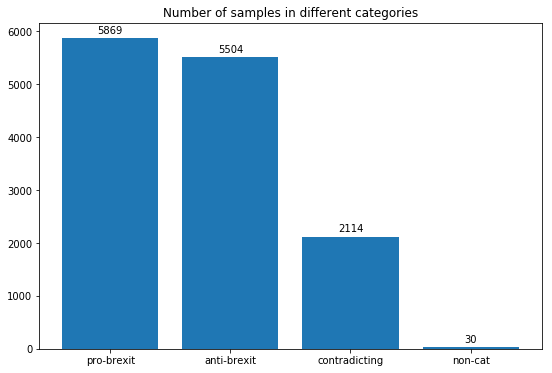

In [4]:
consensus_rate = consensus([str(annotation).split('/') for annotation in df['Annotations']])

x = [rate[0] for rate in consensus_rate]
fig = plt.figure(figsize=(9,6))
ax = fig.add_subplot(111)
bars = ax.bar(Counter(x).keys(), Counter(x).values())
for rect in bars:
    height = rect.get_height()
    ax.annotate('{}'.format(height),
                xy=(rect.get_x() + rect.get_width() / 2, height),
                xytext=(0, 3),  # 3 points vertical offset
                textcoords="offset points",
                ha='center', va='bottom')
plt.title("Number of samples in different categories")


In [5]:
#Remove contradicting opinions
df = remove_conflicts_by_rate(df)

In [6]:
# Substitute the annotations with the most common one
annotations_compacted = compact_annotations(df['Annotations'])

df['Annotations'] = annotations_compacted
df['Comment'] = df['Comment'].apply(clean_comments, remove_sw=False)

# Clean the comments, create a dataframe without stop words
df_no_stopwords = pd.DataFrame.copy(df)
df_no_stopwords['Comment'] = df_no_stopwords['Comment'].apply(clean_comments, remove_sw=True)

In [7]:
df_no_stopwords.head()

,Comment,Annotations
0,people never voted sneaky way saying brexit vo...,1
1,member european union bit like going sandwich ...,0
2,brexit bad immigrants make britain great also ...,0
3,britain basically pompeii pompeii voted volcan...,0
4,britains exit huge blow dream united europe en...,1


In [8]:
df.head()

,Comment,Annotations
0,people who have NEVER voted sneaky way of say...,1
1,Being a member of the European Union is a bit ...,0
2,Brexit is bad Immigrants make Britain great Th...,0
3,Britain is basically Pompeii if the Pompeii ha...,0
4,Britains exit is a huge blow to the dream of a...,1


In [9]:
#Read test data and re-organize
test_df = pd.read_csv('a2a_test_final.tsv', sep='\t', names=['Annotations', 'Comment'])
test_df = reorganize_columns(test_df)
test_df['Comment'] = test_df['Comment'].apply(clean_comments, remove_sw=False)

test_df_no_stopwords = pd.DataFrame.copy(test_df)
test_df_no_stopwords['Comment'] = test_df_no_stopwords['Comment'].apply(clean_comments, remove_sw=True)

In [10]:
test_df.head()

,Comment,Annotations
0,I didnt think about the business side - Every ...,0
1,I had to trigger Article 50 It would have been...,0
2,Uh we want to leave the EU but we want to keep...,0
3,DeathtotheEU oh wow I really hate the EU What ...,1
4,IVotedLeave and I hope you did too! EUref lets...,1


In [11]:
test_df_no_stopwords.head()

,Comment,Annotations
0,didnt think business side - every brexit voter,0
1,trigger article 50 would embarrassing otherwis...,0
2,uh want leave eu want keep benefits,0
3,deathtotheeu oh wow really hate eu bunch arrog...,1
4,ivotedleave hope too! euref lets take back con...,1


In [12]:
xtrain = df["Comment"]
ytrain = df["Annotations"]

xtest = test_df['Comment']
ytest = test_df['Annotations'].apply(str)


xtrain_no_stopwords = df_no_stopwords["Comment"]
ytrain_no_stopwords = df_no_stopwords["Annotations"]

xtest_no_stopwords = test_df_no_stopwords["Comment"]
ytest_no_stopwords = test_df_no_stopwords["Annotations"].apply(str)

In [13]:
# Apply TfidfVectorizer
tf_vec = TfidfVectorizer()
xtrain_transformed = tf_vec.fit_transform(xtrain)
xtest_transformed = tf_vec.transform(xtest)

In [14]:
# Try better classifiers
classifiers = [MultinomialNB(), LogisticRegression(max_iter = 1000), RandomForestClassifier(), AdaBoostClassifier()]
scores = list()
names = ['MultinomialNB', 'Logistic Regression', 'RandomForestClassifier', 'AdaBoostClassifer']
for i, clf in enumerate(classifiers):
    # clf_scores = list()
    scores.append((names[i], mean(cross_val_score(clf, xtrain_transformed, ytrain, cv=5, n_jobs=-1))))

print("Scores:\n")
for i in scores:
    print(i)

print("\nBest classifier: ", max(scores, key=lambda tup: tup[1]))

Scores:

('MultinomialNB', 0.7760482859269139)
('Logistic Regression', 0.7734991833144867)
('RandomForestClassifier', 0.7469443977306774)
('AdaBoostClassifer', 0.6921657726618149)

Best classifier:  ('MultinomialNB', 0.7760482859269139)


In [15]:
#Tune top classifiers and parameters
names = ['MultinomialNB', 'LogisticRegression']
classifiers = [MultinomialNB(), LogisticRegression(max_iter = 1000)]
param_grid = [
            [{'alpha':[i/10 for i in range(5,30)]}],
            [{'C':[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.4]}]
            ]


for name, classifier, parameters in zip(names, classifiers, param_grid):
    
    print("Running {} ...".format(name))
    grid = GridSearchCV(classifier, param_grid = parameters, n_jobs = -1, cv = 5, scoring='accuracy')
    cpx = grid.fit(xtrain_transformed, ytrain)
    score =  cpx.score(xtest_transformed, ytest)
    
    print("Optimized {0} With params: {1}. Score : {2:.4f}\n".format(name, cpx.best_params_, score))


Running MultinomialNB ...
Optimized MultinomialNB With params: {'alpha': 0.8}. Score : 0.7948

Running LogisticRegression ...
Optimized LogisticRegression With params: {'C': 1.8}. Score : 0.8000



In [16]:
# A pipeline that used TfidfVectorizer
def train_document_classifier(X, Y, classifier):
    pipeline = make_pipeline( TfidfVectorizer(), classifier)
    pipeline.fit(X, Y)
    return pipeline

# Returns the Accuracy and F1 score of the given classifier
def acc_and_f1_score_of_classifier(X, Y, X_test, Y_test, classifier):
    trained_clf = train_document_classifier(X, Y, classifier)
    return accuracy_score(Y_test, trained_clf.predict(X_test)), f1_score(Y_test, trained_clf.predict(X_test), pos_label='1')

In [17]:
# LogReg and MultiNB had the best results while testing, so look at accuracy and f1 score

print("Logistic regression. Test data:")
a,f = acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, LogisticRegression(C = 1.8))
print("Accuracy: {0:.3f} \t\t F1 score: {1:.3f}".format(a, f))

print("\nMulinomial Naive Bayes. Test data:")
a,f = acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, MultinomialNB(alpha = 0.8))
print("Accuracy: {0:.3f} \t\t F1 score: {1:.3f}".format(a, f))

Logistic regression. Test data:
Accuracy: 0.800 		 F1 score: 0.812

Mulinomial Naive Bayes. Test data:
Accuracy: 0.795 		 F1 score: 0.815


In [18]:
# Calculating values for table 1
log_reg_clf = LogisticRegression()
print(acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, log_reg_clf))
rf_clf = RandomForestClassifier(n_jobs=-1, max_depth=50, n_estimators=1000)
print(acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, rf_clf))
multiNB_clf = MultinomialNB()
print(acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, multiNB_clf))
clf_base = AdaBoostClassifier(n_estimators=2000)
print(acc_and_f1_score_of_classifier(xtrain, ytrain, xtest, ytest, clf_base))

(0.7974137931034483, 0.8094079480940796)
(0.7922413793103448, 0.8124513618677044)
(0.7931034482758621, 0.813953488372093)
(0.7620689655172413, 0.7802547770700637)


In [19]:
#Now tune hyper parameters for best classifiers but without stopwords
xtrain_transformed_no_sw = tf_vec.fit_transform(xtrain_no_stopwords)
xtest_transformed_no_sw = tf_vec.transform(xtest_no_stopwords)

#Tune best classifiers and parameters
names = ['MultinomialNB', 'LogisticRegression']
classifiers = [MultinomialNB(), LogisticRegression(max_iter = 1000)]
param_grid = [
            [{'alpha':[i/10 for i in range(5,30)]}],
            [{'C':[1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.4]}]
            ]


for name, classifier, parameters in zip(names, classifiers, param_grid):
    print("Running {} ...".format(name))
    grid = GridSearchCV(classifier, param_grid = parameters, n_jobs = -1, cv = 5, scoring='accuracy')
    cpx = grid.fit(xtrain_transformed_no_sw, ytrain)
    score =  cpx.score(xtest_transformed_no_sw, ytest)
    
    print("Optimized {0} With params: {1}. Score : {2:.4f}\n".format(name, cpx.best_params_, score))

Running MultinomialNB ...
Optimized MultinomialNB With params: {'alpha': 0.9}. Score : 0.7862

Running LogisticRegression ...
Optimized LogisticRegression With params: {'C': 2.0}. Score : 0.7810



In [20]:
log_reg_no_sw = train_document_classifier(xtrain_no_stopwords, ytrain_no_stopwords, LogisticRegression(C = 2.0))
multiNB_no_sw = train_document_classifier(xtrain_no_stopwords, ytrain_no_stopwords, MultinomialNB(alpha = 0.9))

# LogReg and MultiNB are the best classifiers, so look at accuracy and f1 score without stopwords


print("Logistic regression. Test data NO stopwords:")
a,f = acc_and_f1_score_of_classifier(xtrain_no_stopwords, ytrain_no_stopwords, xtest_no_stopwords, ytest_no_stopwords, LogisticRegression(C = 2.0))
print("Accuracy: {0:.3f} \t\t F1 score: {1:.3f}".format(a, f))

print("\nMulinomial Naive Bayes. Test data NO stopwords:")
a,f = acc_and_f1_score_of_classifier(xtrain_no_stopwords, ytrain_no_stopwords, xtest_no_stopwords, ytest_no_stopwords, MultinomialNB(alpha = 0.9))
print("Accuracy: {0:.3f} \t\t F1 score: {1:.3f}".format(a, f))

Logistic regression. Test data NO stopwords:
Accuracy: 0.781 		 F1 score: 0.794

Mulinomial Naive Bayes. Test data NO stopwords:
Accuracy: 0.786 		 F1 score: 0.807


32 many conversations good + bad +sad feel retainers bad uk trump usa hun : im loss people dont believe great britain great without eu 
32 After many conversations good + bad +sad I feel retainers are as bad to uk as trump is to usa hun : Im at a loss to why people Dont believe that Great Britain can be Great without the Eu 

58 eu student applying uk universities year please britain! dont leave us 
58 As an EU student applying to UK universities this year please Britain! Dont leave us  

94 boris johnson: capitulates eus demands withdrawal agreement spins victory 
94 Boris Johnson: Capitulates to the EUs demands on the withdrawal agreement and spins it as a victory 

147 brexit biggest threat uk since world war ii people idea bad going get populist arguments leave side frighting last 2 years uk politics completely preoccupied brexit topic moved forward important agenda items something truly rotten state time denmark! 
147 Brexit is the biggest threat to the UK since World War II Peopl

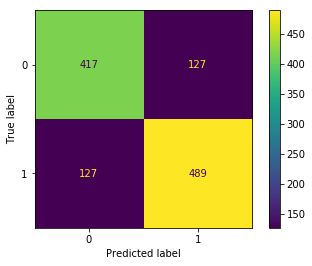

In [21]:
# Get the confusion matrix as well as print out every 10th sentence that the labeling got wrong
# The sentence is printed out with and without stop words
plot_confusion_matrix(log_reg_no_sw, xtest_no_stopwords, ytest_no_stopwords, values_format='n')

Y_pred = log_reg_no_sw.predict(xtest)
count = 0
for num, i in enumerate(range(len(Y_pred))):
    if Y_pred[i] != ytest.iloc[i]:
        count += 1
        if count == 10:
            print(num, xtest_no_stopwords.iloc[i])
            print(num, xtest.iloc[i], "\n")
    count = count % 10

In [22]:
# Getting the weights for the features
sub = log_reg_no_sw[1:]
weights = sub[-1].coef_
weights = np.apply_along_axis(abs, 0, weights)
vectorizer = log_reg_no_sw[:1][-1]
# Finding the ten most weighted features and their equivalent word
indexes = weights.argsort()[0][-10:][::-1]
features = vectorizer.get_feature_names()

In [23]:
# Print out the ten most weighted words
for index in range(len(indexes)):
    print(features[indexes[index]])

remainers
brexiters
sad
remoaners
scotland
democracy
brexiteers
finally
eu
disaster
